<a href="https://colab.research.google.com/github/SmartSoundKAIST/KSNVE2022AISummer/blob/main/6_1_Mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2022년 인공지능 강습회 2일차 실습 코드**
## **Practice 6 : Anomaly Detection using Outlier Exposure**

In anomaly detection (using classification as pretext task), anomaly data is basically unseen during training. However, you can make auxilary dataset that pretends to be anomaly dataset during training. For example, in this exercise normal data is 0,1,2,3 and anomaly data is 7,8,9. Here, you can make auxilary dataset composed of 4,5,6 and train model to behave under confidently. Specifically, model can be trained to make prediction probability as uniform distribution when it get 4,5,6. This method is called **outlier exposure**. Outlier exposure is very easy to implement and increase performance a lot. However it has problem of GPU memory usage and make speed slow. 💻

Here, you will implement outlier exposure and see how performance get better. Also, you will see anomaly score can be H(u;.), which is proposed in this paper.

(Unlike main experiment in Outlier exposure, this code will do outlier exposure in scratch, but if you see Appendix C, author claims that traning from scratch is better than training as fine-tuning.)

If you want, study outlier exposure here. 📖 https://arxiv.org/pdf/1812.04606.pdf.

===============================================================================

In additional to Outlier exposure, there are many other techniques that can improve the performance. If you want, study below papers.

 “A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks”, 2017 ICLR  https://arxiv.org/pdf/1610.02136.pdf

 “Enhancing The Reliability of Out-of-distribution Image Detection in Neural Networks”, 2018 ICLR  https://arxiv.org/pdf/1706.02690.pdf



 “Training Confidence-calibrated Classifiers for Detecting Out-of-Distribution Samples”, 2018 ICLR  https://arxiv.org/pdf/1711.09325.pdf <- This paper suggest to make outlier data using GAN. Outlier exposure criticize this paper and show that Outlier exposure is better than this method.
 

“A Simple Unified Framework for Detecting Out-of-Distribution Samples and Adversarial Attacks”, 2018 NIPS   https://proceedings.neurips.cc/paper/2018/file/abdeb6f575ac5c6676b747bca8d09cc2-Paper.pdf

And for improving Outlier Exposure, follow below paper. (OECC)

https://arxiv.org/pdf/1906.03509.pdf

## 1. Import packages
New library imported for this project: 
- `Scikit-learn` package: includes useful tools for data analysis & preprocessing (https://scikit-learn.org/stable/)
  - We use this package for `anomaly score` metrics
- `Matplot` library: for plotting graphs
- `Torchinfo`: summarizes and print formatted `model information` 

In [1]:
!pip install torchinfo                                                          # install torchinfo module 
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn import metrics
from sklearn.manifold import TSNE 
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib import cm
import torchsummary
from torchinfo import summary
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
plt.rc('font', size=20)

## 2. Hyperparameters
You can change the hyperparameter below.
Parameter `ANOMALY_NUM` means which number to set as an anomaly.

Score mode is option to choose which metric will be used as anomaly score. 0 will be 1 - MSP, and 1 will be -H(u;.). That new metric will be introduced later.

In [4]:
EPOCHS = 5                                                                      # Number of epochs to train
BATCH = 32                                                                      # Minibatch size
ORGCLASS_NUM = 10                                                               # Num of original classes (10: 0 to 9)
ANOMALY_NUM = [7,8,9]                                                           # (list) Digits will be used as anomalous data
NORMAL_NUM =  [0,1,2,3]                                                         # (list) Digits used as normal data  

OUTLIER_NUM = [4,5,6]                                                           # (list) Digits used as ouliter

TEMPSC = 1.0                                                                    # temperature parameter (for temperature scaling)
LBSMOOTH = 0.0                                                                  # label smoothing parameter

SCORE_MODE = 0                                                                  # Anomaly score : 0 for 1-MSP 1 for H(u;.)

The dataset for anomaly detection is composed of normal data and anomaly data. Normal data can be seen in the train, validation, and test dataset, but anomaly data is not in the train dataset. Here digit `0,1,2,3` will be used as `normal data`, and `7,8,9` will be used as `anomaly data`. And `4,5,6` will be used as `outlier exposure data`. 
`TEMPSC` and `LBSMOOTH` are parameters for temperature scaling and label smoothing, respectively.

## 3. Dataset and Dataloader

Here we use MNIST dataset. 
The datatype of the dataset is a TorchTensor of tuples: (`image tensor`, `target label`)

The dimensions of an image tensor is (`channel`=1, `width`=28, `height` =28)

Here, we use `Subset` package in `torch.utils.data` to build two sub-datasets (validation, test).


In [5]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

train_idx = [i for i,v in enumerate(mnist_train) if v[1] in NORMAL_NUM]         # get a list of indices with NORMAL_NUM, v is the tuple of (image tensor, label)
train_dataset = Subset(mnist_train,train_idx)                                   # get a subset of dataset using train_idx
                                     
testdigit = ANOMALY_NUM + NORMAL_NUM                                            # join two list
test_idx =[i for i,v in enumerate(mnist_test) if v[1] in testdigit]
Num_test = int(len(test_idx)/2)

test_dataset = Subset(mnist_test,test_idx[:Num_test])
val_dataset = Subset(mnist_test,test_idx[Num_test:])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

# this is for outlier exposure

outlier_idx = [i for i,v in enumerate(mnist_train) if v[1] in OUTLIER_NUM]
outlier_dataset = Subset(mnist_train,outlier_idx) 
outlier_dataloader = DataLoader(outlier_dataset, batch_size=BATCH, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



Dataset length is like below.

In [6]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
# now print outlier too
print(len(outlier_dataset))

24754
3584
3584
17181


## 4. Define a DNN model 
Now, you will use CNN classifier.

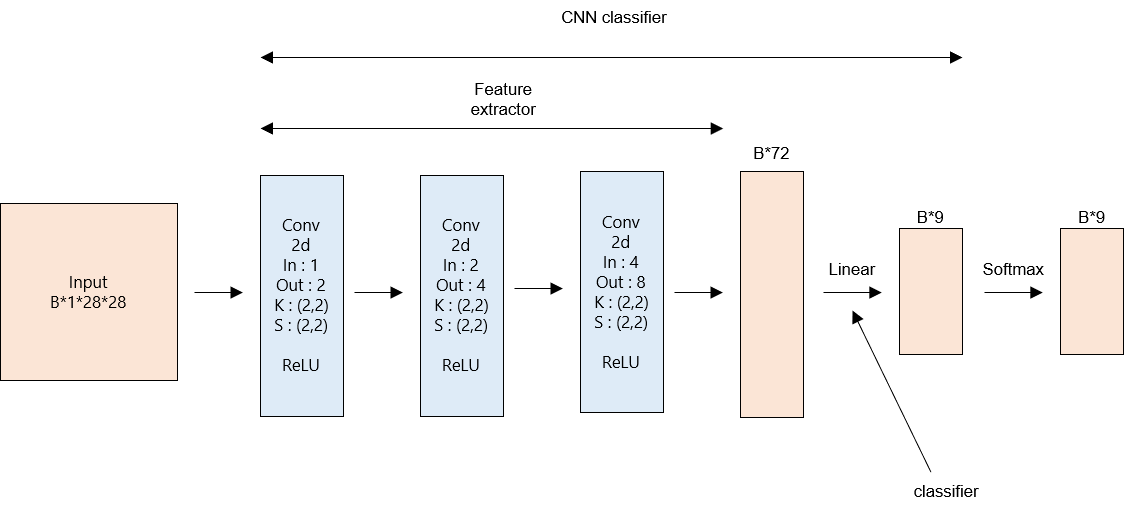

In [7]:
class ClassificationCNNModel(nn.Module):
    def __init__(self, nclass=len(NORMAL_NUM)):
        super(ClassificationCNNModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,2,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(2,4,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(4,8,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(72,nclass),
        )

    def forward(self, x):
        feature = self.feature_extractor(x)
        feature = feature.reshape(feature.shape[0],-1)
        out = self.classifier(feature)
        return out, feature

In [8]:
## Create classification object 
model = ClassificationCNNModel(len(NORMAL_NUM)).to(device)
summary(model,input_size=(BATCH,1,28,28))                                       # summary(model, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
ClassificationCNNModel                   [32, 4]                   --
├─Sequential: 1-1                        [32, 8, 3, 3]             --
│    └─Conv2d: 2-1                       [32, 2, 14, 14]           10
│    └─ReLU: 2-2                         [32, 2, 14, 14]           --
│    └─Conv2d: 2-3                       [32, 4, 7, 7]             36
│    └─ReLU: 2-4                         [32, 4, 7, 7]             --
│    └─Conv2d: 2-5                       [32, 8, 3, 3]             136
│    └─ReLU: 2-6                         [32, 8, 3, 3]             --
├─Sequential: 1-2                        [32, 4]                   --
│    └─Linear: 2-7                       [32, 4]                   292
Total params: 474
Trainable params: 474
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.10
Forward/backward pass size (MB): 0.17
Params size (MB): 0.00
Estimated Total Size (MB): 0.27

### Loss functions & optimizers & Anomaly Score

Loss function is Cateogrical Cross Entropy. This loss is commonly used for multi-class classification. https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

This function gets Softmax probability and a target one-hot vectoras input.

For mode == 0, it will act as you know.

Anomaly score is then calculated in validation and test. 1 - Maximum Softmax Probability is commonly used as an anomaly score when using classification as a pretext task. Since the model has the label of normal only, the model may predict anomaly data as a normal class with lower probability (Under-confident).

For mode == 1, new metric will be used.

Using outlier exposure, model is trained to make uniform distribution when they get non normal data. So, when it gets anomaly data, it will make distribution similar to uniform distribution. Using this property, anomaly score can be designed as -H(u;.) where H is cross categorical entropy and u is uniform distribution.

In [9]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=LBSMOOTH) # CCE
def anomaly_score(logits, mode=0): # mode = 0 : 
    if mode == 0:
      # Anomaly score = 1 - MSP
      softmaxprob = torch.softmax(logits, dim=1)
      MSP = torch.max(softmaxprob, dim=1).values
      return torch.tensor(1) - MSP
    if mode == 1:
      # Anomaly score = -H(u,.)
      uni = torch.ones(logits.shape[0],logits.shape[1]).float().to(device)/ torch.tensor(len(NORMAL_NUM)).float().to(device) # make uniform distribution
      score = -F.cross_entropy(logits,uni,reduction='none') # -CCE (negative since anomaly score should be high for anomaly data)
      #print(score)
      return score
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam as optimizer

## 5. Train & Test classes
The design of train & test classes is quite similar to previous examples. 

### Train

Here, joint training will be implemented. Loss function is designed as below. (This is refered by paper.)

ℒ = ℋ(normal one-hot vector label ; ℱ(normal image)) + 0.5 * ℋ(𝒰;ℱ(outlier exposure image)

where ℒ is total loss, ℱ is classifier (model), ℋ is categorical cross entropy, and 𝒰 is uniform distribution

In [10]:
def train(dataloader, outlier_dataloader, model, loss_fn, optimizer):           # Here, outlier_dataloader is added. Due to this, more GPU memory is used and this is one of the defect of Outlier Exposure.
    model.train()
    size = len(dataloader.dataset)
    losses = []
    in_losses = []
    oe_losses = []
    batch = 0
    for indist, oedist in zip(dataloader, outlier_dataloader):                  # each dist is tuple of (img, label)
        
        # unzip tuple
        
        in_image, in_idx = indist
        oe_image, oe_idx = oedist
        # in distribution dataset (normal data)

        logits, _ = model(in_image.to(device))                                  # logit (batch, class)
        p = F.one_hot(in_idx,ORGCLASS_NUM)[:,NORMAL_NUM] 
        p = p.float().to(device)
        in_dist_loss = loss_fn(logits, p)
        in_losses.append(in_dist_loss.cpu().detach())

        # OE

        outlier_logits, _ = model(oe_image.to(device)) 
        p_oe = torch.ones(oe_image.shape[0],len(NORMAL_NUM)) / torch.tensor(len(NORMAL_NUM)) # uniform dist.
        p_oe = p_oe.float().to(device)
        oe_loss = loss_fn(outlier_logits, p_oe)                                 # CCE
        oe_losses.append(oe_loss.cpu().detach())

        # joint training

        loss = in_dist_loss + 0.5*oe_loss                                       # 0.5 for visual task
        losses.append(loss.cpu().detach())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * logits.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        batch += 1

    return np.mean(losses), np.mean(in_losses), np.mean(oe_losses)

Anomaly score is calculated over validation and test datasets. Since the model is trained with normal data, the model may not classify anomaly data with high confidence, so the anomaly score of anomaly data will be higher than the anomaly score of normal data. Using difference in anomaly score distributions, ROC-AUC (Area Under Curve) can be calculated.

### Test

In [11]:
def test(dataloader, model, loss_fn, anomaly_score, valid_mode = True,  draw_mode = False, OE_mode = False, score_mode = 0): # OE_mode is added to collect feature of OE.
    model.eval()

    y_true, y_pred = [], []

    normal_loss = []
    normal_scores = []
    anomaly_scores  =[]
    outfeature = []  
    total_labels = []

    with torch.no_grad():
      
        for Imgs, labels in dataloader:

            Imgs = Imgs.to(device)                                              # upload to GPU
            logits, features = model(Imgs)                                      # logits out (idx,class), features out (idx, num_feature )
            logits = logits/TEMPSC                                              # temperature scaling
            if not valid_mode:
                outfeature.append(features)                                     # append features to tensor list for t-SNE plot 
                total_labels.append(labels)

            score = anomaly_score(logits,score_mode)                            # anomaly score (idx)
            
            # We do nothing if label does not belong to NORMAL_NUM or ANOMALY_NUM
            for idata in range(logits.shape[0]):
                score_ = score[idata].item()
                if labels[idata] in NORMAL_NUM:                                 # for normal data

                    # calc CE loss for normal data
                    p = F.one_hot(labels[idata],10)[NORMAL_NUM].reshape(1,-1)
                    logit = logits[idata,:].reshape(1,-1)
                    loss = loss_fn(logit.to(device), p.float().to(device))      # Cross-Entropy loss for normal
                    normal_loss.append(loss.cpu())
                    
                    # record scores
                    y_true.append(0.)
                    y_pred.append(score_)
                    normal_scores.append(score_)

                elif labels[idata] in ANOMALY_NUM:                              # for abnormal data
                    y_true.append(1.)
                    y_pred.append(score_)
                    anomaly_scores.append(score_)
        if not OE_mode:
          roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')

    if not OE_mode:
      print(f'AUC: {roc_auc:>0.3f}')
      
      normal_loss_mean = np.mean(normal_loss)
      normal_score_mean = np.mean(normal_scores)
      anomaly_score_mean = np.mean(anomaly_scores)

      print(f'normal loss : {normal_loss_mean}')
    if not valid_mode:
      outfeature = torch.cat(outfeature, dim=0).cpu().numpy()
      total_labels = torch.cat(total_labels, dim=0).cpu().numpy()
    if not OE_mode:
      return roc_auc.item(), normal_loss_mean, normal_score_mean, anomaly_score_mean, normal_scores, anomaly_scores, outfeature, total_labels
    elif OE_mode:
      return outfeature, total_labels

## 6. Run Trainer 
Now all the classes are defined. Let's see how classification loss and AUC changes during training.

Loss is calculated during train, and AUC is calculated during validation.

In [12]:
train_losses = []
val_normal_losses= []
val_normal_scores = []
val_anomaly_scores = []
roc_auc = []

in_losses = []
oe_losses = []

best_auc = 0.0
best_model = model.to(device)

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loss, in_loss, oe_loss = train(train_dataloader, outlier_dataloader, model, loss_fn, optimizer)
    auc,val_normal_loss, val_normal_score, val_anomaly_score, _, _, _, _ = test(val_dataloader, model, loss_fn, anomaly_score, valid_mode=True, score_mode = SCORE_MODE)

    train_losses.append(train_loss)
    in_losses.append(in_loss)
    oe_losses.append(oe_loss)
    val_normal_losses.append(val_normal_loss)
    val_normal_scores.append(val_normal_score)
    val_anomaly_scores.append(val_anomaly_score)

    roc_auc.append(auc)

    if auc > best_auc:
        best_model,  best_auc = model,  auc

Epoch 1
-------------------------------
loss: 2.084517  [    0/24754]
loss: 1.215669  [ 9600/24754]
AUC: 0.922
normal loss : 0.23093147575855255
Epoch 2
-------------------------------
loss: 1.226230  [    0/24754]
loss: 1.033881  [ 9600/24754]
AUC: 0.953
normal loss : 0.18045420944690704
Epoch 3
-------------------------------
loss: 0.941975  [    0/24754]
loss: 1.007283  [ 9600/24754]
AUC: 0.957
normal loss : 0.17305998504161835
Epoch 4
-------------------------------
loss: 0.977873  [    0/24754]
loss: 0.963401  [ 9600/24754]
AUC: 0.963
normal loss : 0.16033510863780975
Epoch 5
-------------------------------
loss: 0.992795  [    0/24754]
loss: 0.949060  [ 9600/24754]
AUC: 0.967
normal loss : 0.14697322249412537


#### Plot train results

<Figure size 432x288 with 0 Axes>

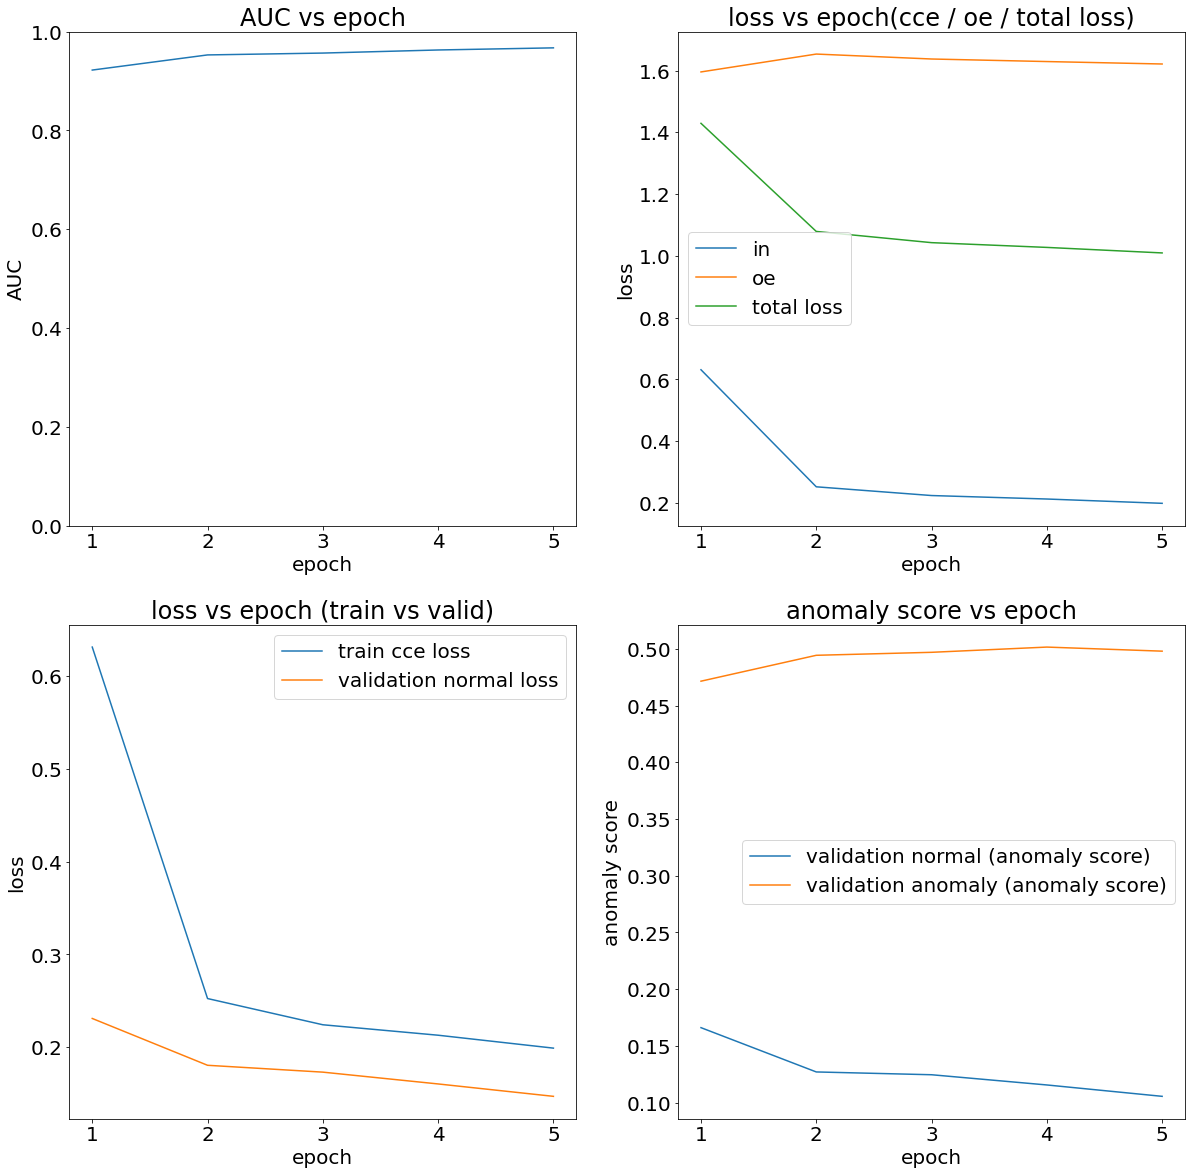

In [13]:
plt.clf()
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.plot(list(range(1,len(roc_auc)+1)),roc_auc)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(2,2,2)
plt.plot(list(range(1,len(in_losses)+1)),in_losses)
plt.plot(list(range(1,len(oe_losses)+1)),oe_losses)
plt.plot(list(range(1,len(train_losses)+1)),train_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch(cce / oe / total loss)')
plt.legend(['in', 'oe', 'total loss'])

plt.subplot(2,2,3)
plt.plot(list(range(1,len(in_losses)+1)),in_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch (train vs valid)')
plt.legend(['train cce loss', 'validation normal loss'])

plt.subplot(2,2,4)
plt.plot(list(range(1,len(val_normal_scores)+1)),val_normal_scores)
plt.plot(list(range(1,len(val_anomaly_scores)+1)),val_anomaly_scores)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal (anomaly score)','validation anomaly (anomaly score)'])

## 7. Performance on test data.
### 7-1. ROC-AUC

AUC: 0.936
normal loss : 0.20529435575008392


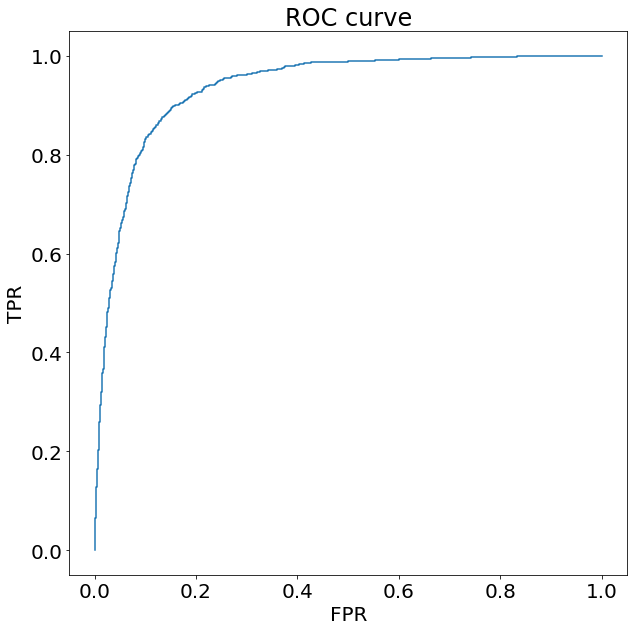

In [14]:
test_auc,test_normal_loss, test_normal_score, test_anomaly_score, test_normal_scores, test_anomaly_scores, best_features, total_labels \
= test(test_dataloader, best_model, loss_fn, anomaly_score, valid_mode=False, draw_mode=True,score_mode=SCORE_MODE)

# this is for OE features
oe_features, oe_labels = test(outlier_dataloader, best_model, loss_fn, anomaly_score, valid_mode=False, draw_mode=False, OE_mode = True)

### 7-2. Histogram of anomaly score 

<Figure size 720x720 with 0 Axes>

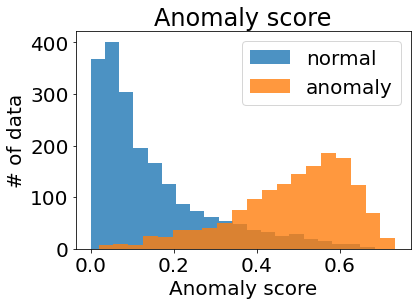

<Figure size 720x720 with 0 Axes>

In [15]:
#@title 기본 제목 텍스트
plt.hist(test_normal_scores,  bins = 20, alpha = 0.8) # 'bins' are related to the number of bins.
plt.hist(test_anomaly_scores, bins = 20, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'])
plt.figure(figsize=(10,10))

## 8. Predicted Probability (In dist. vs Out dist)
Below code plots figure of the original input image and predicted probability for each class.

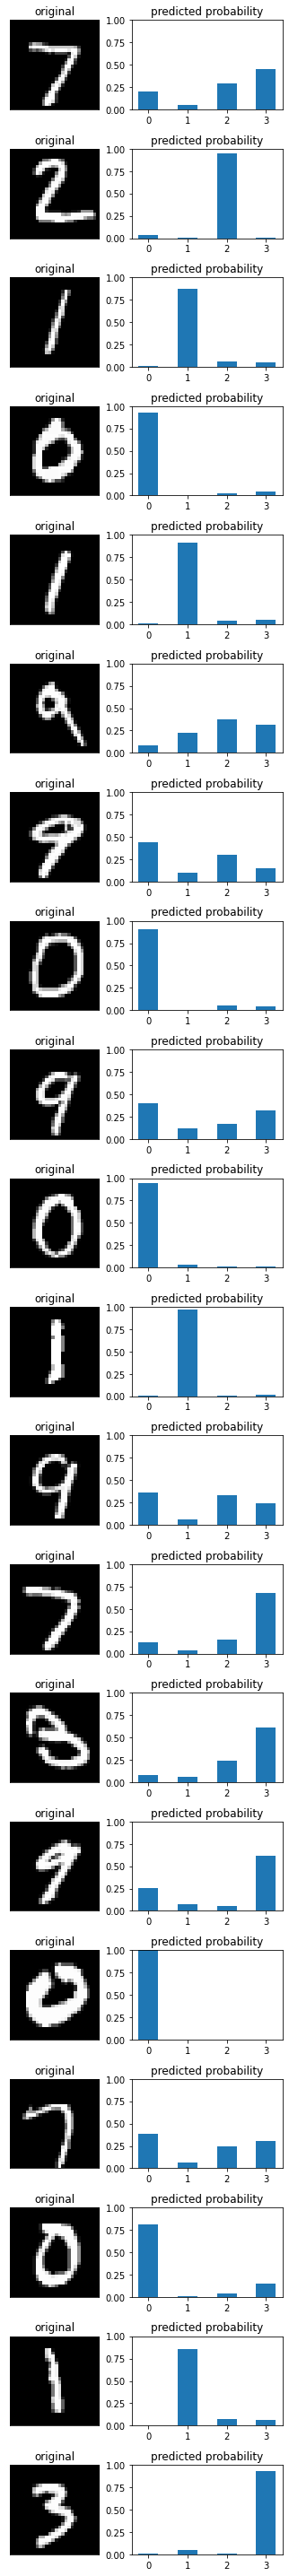

In [23]:
n = 20                                                                          # the number of data to be plotted
plt.figure(figsize=(5, 40))                                                     # total figure size
plt.rc('font', size=10)

for i in range(n):
    input_image = test_dataset[i][0].to(device)
    pred_prob = torch.softmax(best_model(input_image.unsqueeze(0))[0],dim=1).cpu().detach().squeeze().numpy()

    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(input_image[0].cpu())                                            # show input image
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax2 = plt.subplot(n, 2, 2*i+2)
    ax2.set_ylim([0,1])

    classify_as = [str(i) for i in NORMAL_NUM]
    plt.bar(classify_as, pred_prob, width = 0.5, tick_label = classify_as)      # print predicted probability for each class

    plt.title('predicted probability')
    plt.tight_layout()

plt.show()

As you see, normal data is predicted with a high probability compared to anomaly data. 

This means normal data have higher MSP, which is anomaly score, and anomaly data have lower MSP.

Using this difference of anomaly score, anomaly detection can be done.

### Predicted Probability (OE)

For OE, classifier predict as uniform dist.

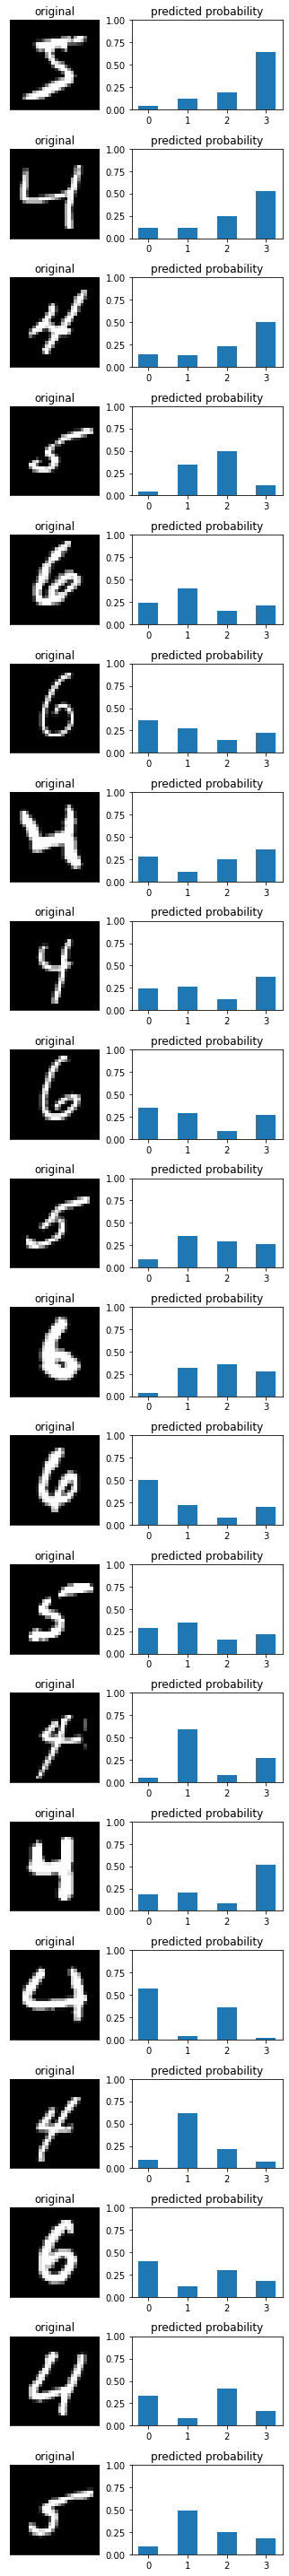

In [24]:
n = 20 # the number of data to be plotted
plt.figure(figsize=(5, 40)) # total figure size
plt.rc('font', size=10)

for i in range(n):
    input_image = outlier_dataset[i][0].to(device)
    pred_prob = torch.softmax(best_model(input_image.unsqueeze(0))[0],dim=1).cpu().detach().squeeze().numpy()

    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(input_image[0].cpu())                                            # show input image
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax2 = plt.subplot(n, 2, 2*i+2)
    ax2.set_ylim([0,1])

    classify_as = [str(i) for i in NORMAL_NUM]
    plt.bar(classify_as, pred_prob, width = 0.5, tick_label = classify_as)      # print predicted probability for each class

    plt.title('predicted probability')
    plt.tight_layout()

plt.show()

## 9. t-SNE visualization 
Here, we visualize the feature space using t-SNE visualization tool

In [18]:
# Create a two dimensional t-SNE projection of the feature embeddings
tsne = TSNE(2, verbose=1)                                                       #2D visualization
tsne_proj = tsne.fit_transform(best_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3584 samples in 0.000s...
[t-SNE] Computed neighbors for 3584 samples in 0.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3584
[t-SNE] Computed conditional probabilities for sample 2000 / 3584
[t-SNE] Computed conditional probabilities for sample 3000 / 3584
[t-SNE] Computed conditional probabilities for sample 3584 / 3584
[t-SNE] Mean sigma: 1.743128
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.191246
[t-SNE] KL divergence after 1000 iterations: 1.378884


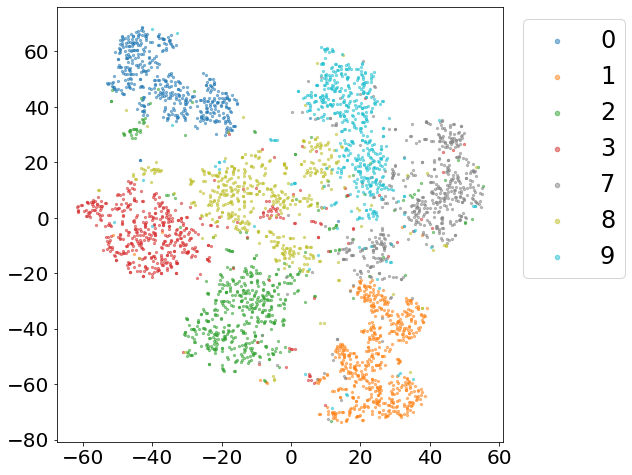

In [19]:
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(8,8))
TOTAL_NUM = NORMAL_NUM + ANOMALY_NUM
num_categories = len(TOTAL_NUM)
for ilabel in TOTAL_NUM:
    indices = total_labels==ilabel
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(ilabel)).reshape(1,4), s=5, label = ilabel ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2, loc='upper right', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))
plt.show()

### t-SNE visuliazation including OE

In [20]:
all_features = np.vstack((best_features,oe_features))
all_labels = np.hstack((total_labels,oe_labels))

In [21]:
# Create a two dimensional t-SNE projection of the feature embeddings
tsne_all = TSNE(2, verbose=1) #2D visualization
tsne_all_proj = tsne_all.fit_transform(all_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20765 samples in 0.002s...
[t-SNE] Computed neighbors for 20765 samples in 10.444s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20765
[t-SNE] Computed conditional probabilities for sample 2000 / 20765
[t-SNE] Computed conditional probabilities for sample 3000 / 20765
[t-SNE] Computed conditional probabilities for sample 4000 / 20765
[t-SNE] Computed conditional probabilities for sample 5000 / 20765
[t-SNE] Computed conditional probabilities for sample 6000 / 20765
[t-SNE] Computed conditional probabilities for sample 7000 / 20765
[t-SNE] Computed conditional probabilities for sample 8000 / 20765
[t-SNE] Computed conditional probabilities for sample 9000 / 20765
[t-SNE] Computed conditional probabilities for sample 10000 / 20765
[t-SNE] Computed conditional probabilities for sample 11000 / 20765
[t-SNE] Computed conditional probabilities for sample 12000 / 20765
[t-SNE] Computed conditional probabilities for sa

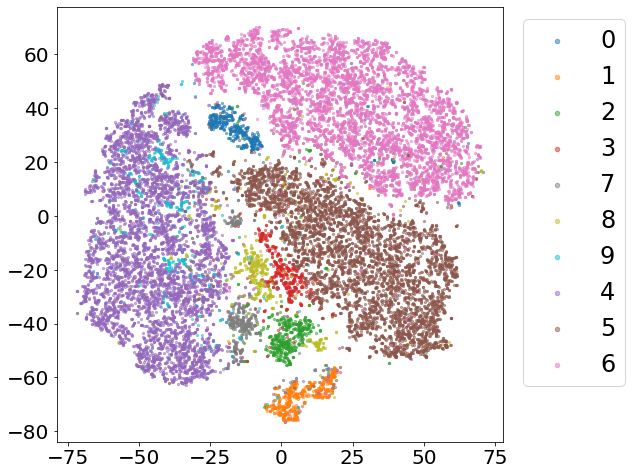

In [22]:
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(8,8))
TOTAL_NUM = NORMAL_NUM + ANOMALY_NUM + OUTLIER_NUM
num_categories = len(TOTAL_NUM)
for ilabel in TOTAL_NUM:
    indices = all_labels==ilabel
    ax.scatter(tsne_all_proj[indices,0],tsne_all_proj[indices,1], c=np.array(cmap(ilabel)).reshape(1,4), s=5, label = ilabel ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2, loc='upper right', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))
plt.show()

Although the paper was not inteded to show, you can see that outlier exposure made decision regions more limited. And this cause in distribution data, (normal data in other words) more concentrated. And due to concentrated normal data in feature space, classifier can more easily do anomaly detection.